# Machine Learning Notebook: Kernels, Kernel SVM and other fun stuff

In [51]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold

# Set plot style
sns.set(style='whitegrid')

## Symmetric Positive Kernels

Let $\mathcal{X}$ be a feature space. We say that
$$K : \mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R} $$
is a symmetric positive kernel on $\mathcal{X}$ when $\forall n \geq 1, \forall x_1, \dots, x_n \in \mathcal{X}$, the matrix $(K(x_i, x_j))_{1 \leq i, j \leq n} \in \mathcal{S}_n^{+} (\mathbb{R})$

When $n$ and $x_1, \dots, x_n \in \mathcal{X}$ are fixed, the matrix $(K(x_i, x_j))_{1 \leq i, j \leq n}$ is usually refered to as the kernel matrix.

The following block of code lets you vizualize the kernel matrices of two kernels in a toy example.

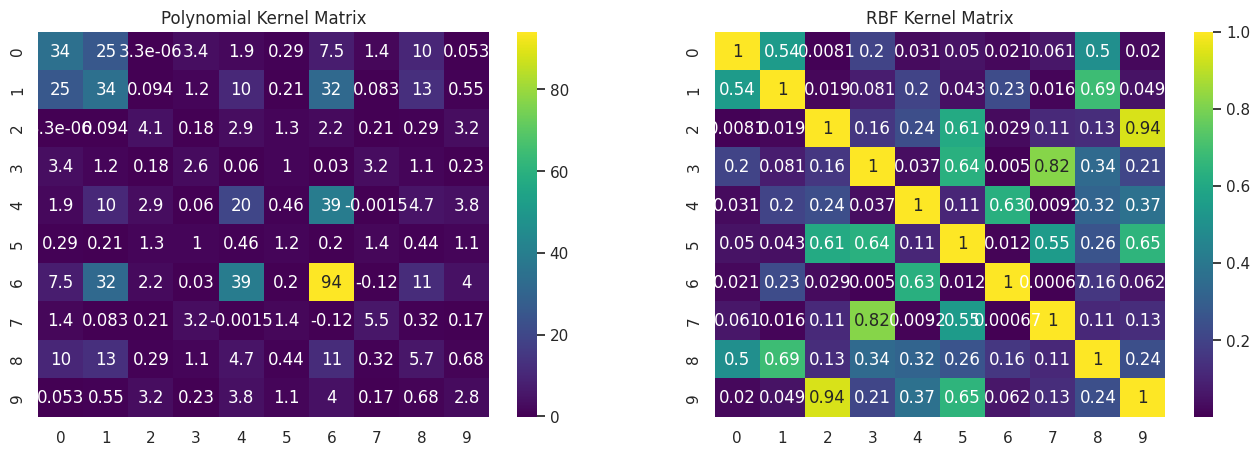

In [52]:
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel, linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns

# Toy dataset
X = np.random.randn(10, 2)

# Compute kernel matrices
K_poly = polynomial_kernel(X, degree=3)
K_rbf = rbf_kernel(X, gamma=0.5)

# Visualize the kernel matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.heatmap(K_poly, ax=axes[0], annot=True, cmap='viridis')
axes[0].set_title("Polynomial Kernel Matrix")
sns.heatmap(K_rbf, ax=axes[1], annot=True, cmap='viridis')
axes[1].set_title("RBF Kernel Matrix")
plt.show()

**Question 1**

Quickly justify why the functions polynomial_kernel and rbf_kernel in the previous code define symmetric positive kernels. You can use the sklearn documentation to obtain more information on those functions.

Polynomial_kernel :  
D'après la documentation présente pour la fonction `polynomial_kernel`, la fonction est de la forme :  

$ K(X, Y) = (\gamma \langle X, Y \rangle + r)^d $

On voit facilement que K(X,Y) = K(Y,X) donc symétrique.

Ensuite, nous savons d'après le cours que $\langle X, Y \rangle$ est un noyau positif (noyau linéaire). D'après les règles d'addition et de produit, $K(X, Y)$ reste donc bien un noyau symmétrique positif.

rbf_kernel :  

D'après la documentation présente pour la fonction `rbf_kernel`, la fonction est de la forme :  

$ K(X, Y) = e^{-\gamma \| X - Y \|^2} $  

On reconnait que $K(X, Y) = f(X-Y)$ où $f$ est une fonction Gaussienne et est donc la transformée de fourier inverse d'une Gaussienne positive. Le théorème de Bochner assure donc que $K$ est un soyau symmétrique positif.

**Question 2**

What property of the kernel matrices can we immediately see in the previous plots ?

On peut clairement voir que les deux matrices sont symétriques comme on pouvait s'y attendre.  


## Kernel SVM

Let $(x_1, y_1), \dots, (x_n, y_n) \in \mathcal{X} \times \{-1, 1 \}$, the point of the $2$-classes classification problem is to build a function $f$ such that
$$ f(x) \approx y $$
on unseen data $(x, y)$.

As we saw in class, linear SVM is a machine learning method that estimates a $2$-classes predictor by a function of the form
$$ f(x) = \text{sgn} \bigg( \hat{\theta}^T \phi(x) \bigg)$$
where
$$ \hat{\theta} \in \text{argmin}_{\theta} \frac{1}{n} \sum_{i=1}^n (1 - y_i\theta^T \phi(x_i))_+ + \lambda \| \theta\|^2 \;.$$

In comparison, Kernel SVM is a machine learning method that estimates a $2$-classes predictor by a function of the form
$$ f(x) = \text{sgn} \bigg( \alpha_1 K(x_1, x) + \dots + \alpha_n K(x_n, x) \bigg)$$
where the $\alpha$'s minimize the following expression :    
$$ \sum_{i = 1}^n \bigg(1 - y_i \bigg( \alpha_1 K(x_1, x_i) + \dots + \alpha_n K(x_n, x_i) \bigg)\bigg)_+ + \lambda \sum_{1 \leq i, j \leq n} \alpha_i \alpha_j K(x_i, x_j) \;.$$

**Question 3**

We denote by $H$ a Hilbert Space with Hilbert product $\langle \cdot, \cdot \rangle$ and by $\phi : \mathcal{X} \rightarrow H$ the space and mapping given by Aronszajn’s theorem such that
$$\forall x_1, x_2 \in \mathcal{X}, \quad k(x_1, x_2) = \langle \phi (x_1), \phi(x_2) \rangle \;.$$

Using the representer theorem, show that the previous expression for $f$ and the related problem for the $\alpha$s is a consequence of the (in)finite-dimensional linear SVM problem

$$ f(x) = \text{sgn} \bigg( \langle \hat{\theta}, \phi(x) \rangle \bigg)$$
where
$$ \hat{\theta} \in \text{argmin}_{\theta \in H} \frac{1}{n} \sum_{i=1}^n (1 - y_i\langle \theta, \phi(x_i) \rangle)_+ + \lambda \| \theta\|_H^2 \;.$$

In the end, what is the difference between a linear SVM and a kernel SVM ?

Le SVM classique cherche une séparation linéaire dans l'espace des $x$'s alors que le SVM à noyau cherche une séparation dans l'espace des $\phi(x)$'s. La régularisation classique $l_2$ devient une régularisation par la norme dans l'espace de Hilbert.

The following code uses this method on a toy example called the "two moons" dataset. Warning : the two classes are encoded on $\{0, 1 \}$ instead of $\{-1, 1 \}$, remember to switch between the two encodings when needed.

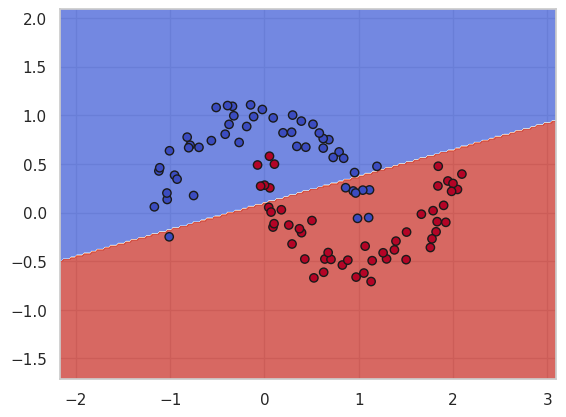

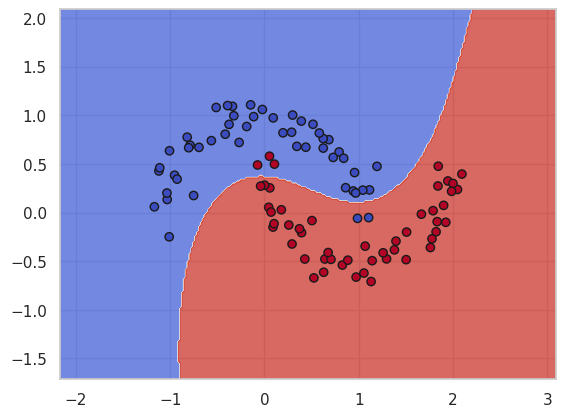

In [53]:
from sklearn.svm import SVC , LinearSVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate a toy dataset
X, y = make_moons(n_samples=100, noise=0.1)

# Train Kernel SVM
clf_1 = LinearSVC(C=1.)
#clf_1 = SVC(kernel = 'linear', C=1.) est similaire
clf_1.fit(X, y)

clf_2 = SVC(kernel = 'rbf',C=1., gamma = 0.5)
clf_2.fit(X, y)

# Visualize the decision boundary
def plot_decision_boundary(model, X, y):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.show()

plot_decision_boundary(clf_1, X, y)
plot_decision_boundary(clf_2, X, y)

**Question 4**

By modifying the previous cell (Copy-Paste the moddified versions below), present two examples, one with a clear underfitting situation, and one with a clear overfitting situation. The meaningful parametters to play with are the kernel type in SVC, the regularization parametter in SVC and the noise level in the data generation.

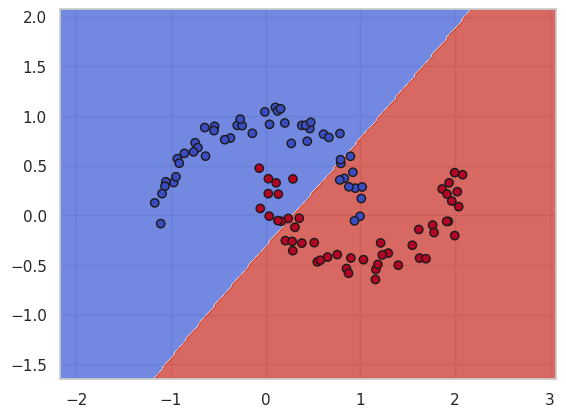

In [54]:
# Generate a toy dataset
X, y = make_moons(n_samples=100, noise=0.1)

# Train Kernel SVM
clf = SVC(kernel='rbf', C=0.1, gamma=0.1)
clf.fit(X, y)

# Visualize the decision boundary
def plot_decision_boundary(model, X, y):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.show()

plot_decision_boundary(clf, X, y)

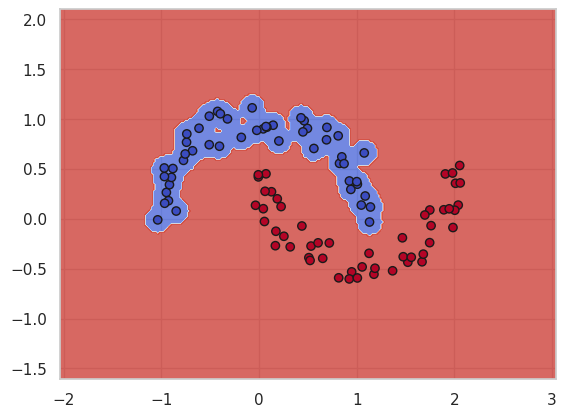

In [55]:
# Generate a toy dataset
X, y = make_moons(n_samples=100, noise=0.1)

# Train Kernel SVM
clf = SVC(kernel='rbf', C=1., gamma=200)
clf.fit(X, y)

# Visualize the decision boundary
def plot_decision_boundary(model, X, y):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.show()

plot_decision_boundary(clf, X, y)

La différence entre un gamma petit et un gamma grand est le fait qu'il va faire varier la région de similarité. Pour un gamma petit, dans notre cas, la région de similarité va être plus grande et ainsi deux observations peu similaires ne vont pas converger vers 0 aussi rapidement que souhaité donc elles vont être considérées comme 'proches', ce qui va fausser la séparation avec quelque chose de très peu intéressant. Dans le cas d'un gamma grand, la région de similarité sera bien plus petite ce qui va faire qu'on va vraiment forcer la sépération des données qui ne sont pas similaires et ainsi créer un sur-apprentissage.

## Kernel SVM By Hand

Now that we have played with Kernel SVMs a bit, let's implement one ourselves (instead of using an already made library) !

**Question 5**

We will train by hand the kernel SVM model using Gradient Descent. Give the expression of the (sub)gradient of the objective gradient with respect to $\alpha_1, \dots, \alpha_n$.

On veut obtenir l'expression du gradient de la fonction suivante :  

$ L(\alpha) = \sum_{i = 1}^n \bigg(1 - y_i \bigg( \alpha_1 K(x_1, x_i) + \dots + \alpha_n K(x_n, x_i) \bigg)\bigg)_+ + \lambda \sum_{1 \leq i, j \leq n} \alpha_i \alpha_j K(x_i, x_j) \;$  

$
f_i(\alpha) := \sum_{j=1}^n \alpha_j K(x_j,x_i),
\qquad
\ell_i(\alpha) := \bigl(1 - y_i f_i(\alpha)\bigr)_+ .
$


Pour $k \in \{1,\dots,n\}$,
$
\frac{\partial}{\partial \alpha_k}\,\ell_i(\alpha)
\;\in\;
-\,y_i K(x_k,x_i)\,\mathbf{1}_{\{y_i f_i(\alpha) < 1\}},
$
(au point $y_i f_i(\alpha)=1$, le sous-gradient appartient à
$[-y_i K(x_k,x_i),\,0]$).

Ainsi, un sous-gradient du premier terme de $L$ est
$
\frac{\partial}{\partial \alpha_k}
\sum_{i=1}^n \bigl(1-y_i f_i(\alpha)\bigr)_+
\;\in\;
- \sum_{i=1}^n y_i K(x_k,x_i)\,\mathbf{1}_{\{y_i f_i(\alpha)<1\}} .
$


On écrit
$
\lambda \sum_{i,j=1}^n \alpha_i \alpha_j K(x_i,x_j)
= \lambda\,\alpha^\top K \alpha ,
$
et, par symétrie de $K$,
$
\frac{\partial}{\partial \alpha_k}
\Bigl(\lambda \sum_{i,j=1}^n \alpha_i \alpha_j K(x_i,x_j)\Bigr)
=
2\lambda \sum_{i=1}^n \alpha_i K(x_k,x_i).
$

\paragraph{Sous-gradient final.}
Pour tout $k \in \{1,\dots,n\}$,
$
\boxed{
\frac{\partial}{\partial \alpha_k} L(\alpha)
\;\in\;
- \sum_{i=1}^n y_i K(x_k,x_i)\,\mathbf{1}_{\{y_i f_i(\alpha)<1\}}
\;+\;
2\lambda \sum_{i=1}^n \alpha_i K(x_k,x_i)
}
$
avec $f_i(\alpha)=\sum_{j=1}^n \alpha_j K(x_j,x_i)$.

In [56]:
import numpy as np

# Gradient (sous-gradient) de
# L(α) = Σ_i (1 - y_i (Kα)_i )_+ + λ α^T K α
# Hypothèses: K symétrique (matrice Gram), y ∈ {−1,+1} (ou transformé depuis {0,1})
def grad_SVM(K, alpha, y, l):
    """
    Renvoie un sous-gradient de l'objectif SVM noyau.

    Paramètres :
        - K : matrice (n,n) (Gram) avec K[i,j] = K(x_i, x_j)
        - alpha : vecteur (n,)
        - y : labels (n,) dans {-1, +1} (si {0,1}, convertir via y = 2*y-1)
        - l : paramètre de régularisation λ

    Sortie :
        - g : vecteur (n,) représentant un sous-gradient de L en alpha
    """
    n = len(alpha)
    y = np.asarray(y).reshape(-1)
    alpha = np.asarray(alpha).reshape(-1)

    if y.shape[0] != n or K.shape != (n, n):
        raise ValueError("Dimensions incohérentes entre K, alpha et y.")

    # Si y est en {0,1}, on convertit en {-1,+1}
    uniq = np.unique(y)
    if np.all(np.isin(uniq, [0, 1])):
        y = 2 * y - 1

    f = K @ alpha

    # indicatrice des points actifs du hinge: 1{1 - y_i f_i > 0}
    active = (1 - y * f) > 0

    g = -(K @ (y * active.astype(float))) + 2 * l * (K @ alpha)

    return g

**Question 6**

Complete the following script in order to implement your own Kernel SVM class.

In [59]:
import numpy as np


def grad_SVM(K, alpha, y, lam):
    n = len(alpha)
    y = np.asarray(y).reshape(-1)
    alpha = np.asarray(alpha).reshape(-1)

    if y.shape[0] != n or K.shape != (n, n):
        raise ValueError("Dimensions incohérentes entre K, alpha et y.")

    # Convertit y ∈ {0,1} -> {-1,+1} si besoin
    uniq = np.unique(y)
    if np.all(np.isin(uniq, [0, 1])):
        y = 2 * y - 1

    f = K @ alpha
    active = (1 - y * f) > 0

    g = -(K @ (y * active.astype(float))) + 2 * lam * (K @ alpha)
    return g


class SVM:
    """
    Petit SVM noyau (classification binaire) entraîné par descente de gradient
    sur l'objectif hinge + régularisation quadratique.
    Labels attendus: y ∈ {-1,+1} (ou {0,1} converti automatiquement).
    """

    def __init__(self, kernel="linear", C=1.0, max_iter=1000000, lr=0.000005, tol=1e-12, **kwargs):
        """
        Paramètres
        ----------
        kernel : {"linear","polynomial","rbf"} ou fonction callable (X1,X2)->K
        C : float (ici utilisé comme λ, poids de régularisation dans λ α^T K α)
        max_iter : int
        lr : float, pas de gradient
        tol : float, tolérance d'arrêt
        kwargs : paramètres noyau (gamma, degree, coef0, ...)
        """
        self.kernel = kernel
        self.C = float(C)
        self.max_iter = int(max_iter)
        self.lr = float(lr)
        self.tol = float(tol)
        self.kernel_params = dict(kwargs)

    # ------------------- Kernels -------------------
    def _linear(self, X1, X2):
        return X1 @ X2.T

    def _polynomial(self, X1, X2):
        gamma = self.kernel_params.get("gamma", 1.0 / X1.shape[1])
        degree = self.kernel_params.get("degree", 3)
        coef0 = self.kernel_params.get("coef0", 1.0)
        return (gamma * (X1 @ X2.T) + coef0) ** degree

    def _rbf(self, X1, X2):
        gamma = self.kernel_params.get("gamma", 1.0 / X1.shape[1])
        # ||x-y||^2 = ||x||^2 + ||y||^2 - 2 x·y
        X1_sq = np.sum(X1**2, axis=1, keepdims=True)      # (n1,1)
        X2_sq = np.sum(X2**2, axis=1, keepdims=True).T    # (1,n2)
        d2 = X1_sq + X2_sq - 2 * (X1 @ X2.T)
        return np.exp(-gamma * d2)

    def _calc_K(self, X1, X2):
        if callable(self.kernel):
            return self.kernel(X1, X2, **self.kernel_params) if self.kernel_params else self.kernel(X1, X2)

        if self.kernel == "linear":
            return self._linear(X1, X2)
        if self.kernel == "polynomial":
            return self._polynomial(X1, X2)
        if self.kernel == "rbf":
            return self._rbf(X1, X2)

        raise ValueError(f"Kernel inconnu: {self.kernel}")

    # ------------------- Optimization -------------------
    def _descente_gradient(self, K, y):
        n = len(y)
        alpha = np.zeros(n)

        # y ∈ {-1,+1} (ou converti)
        y = np.asarray(y).reshape(-1)
        uniq = np.unique(y)
        if np.all(np.isin(uniq, [0, 1])):
            y = 2 * y - 1

        prev_pred = None
        for it in range(self.max_iter):
            g = grad_SVM(K, alpha, y, lam=self.C)
            alpha_new = alpha - self.lr * g

            pred = np.sign(K @ alpha_new)
            if prev_pred is not None and np.linalg.norm(pred - prev_pred) < self.tol:
                # print(f"Convergence atteinte à l'itération {it}")
                alpha = alpha_new
                break

            prev_pred = pred
            alpha = alpha_new

        return alpha

    # ------------------- API -------------------
    def fit(self, X, y, precomputed_kernel_train=None):
        self.X_train = np.asarray(X)
        y = np.asarray(y).reshape(-1)

        if precomputed_kernel_train is None:
            K = self._calc_K(self.X_train, self.X_train)
        else:
            K = np.asarray(precomputed_kernel_train)

        if K.shape != (self.X_train.shape[0], self.X_train.shape[0]):
            raise ValueError("La matrice de noyau train doit être de taille (n_train, n_train).")

        self.alpha = self._descente_gradient(K, y)
        return self

    def decision_function(self, X, precomputed_kernel_train_eval=None):
        X = np.asarray(X)
        if precomputed_kernel_train_eval is None:
            K_eval = self._calc_K(X, self.X_train)  # (n_eval, n_train)
        else:
            K_eval = np.asarray(precomputed_kernel_train_eval)

        if K_eval.shape[1] != self.X_train.shape[0]:
            raise ValueError("K_eval doit avoir n_train colonnes (kernel entre X_eval et X_train).")

        return K_eval @ self.alpha

    def predict(self, X, precomputed_kernel_train_eval=None):
        scores = self.decision_function(X, precomputed_kernel_train_eval)
        return np.sign(scores)

Your code should work on the following examples :

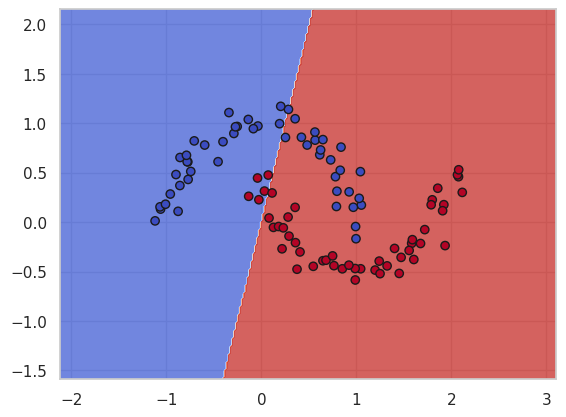

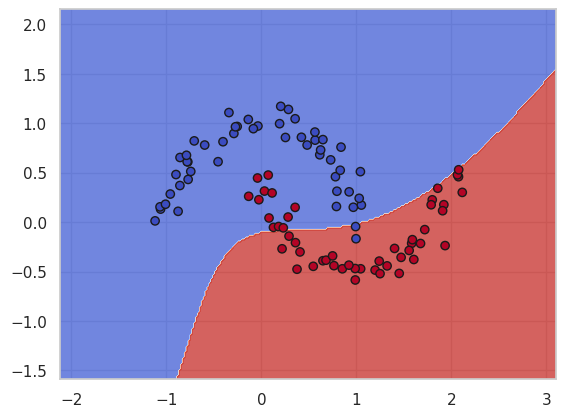

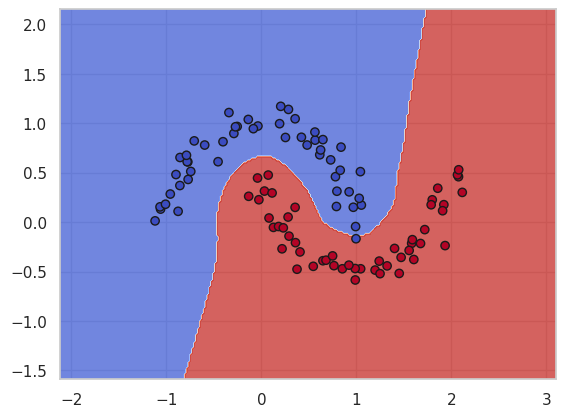

In [60]:
# Generate a toy dataset
X, y = make_moons(n_samples=100, noise=0.1)

## Linear Kernel

# Train Kernel SVM
clf = SVM(kernel='linear', C=1.)
clf.fit(X, y)

# Visualize the decision boundary
plot_decision_boundary(clf, X, y)

## Polynomial Kernel

# Train Kernel SVM
clf = SVM(kernel="polynomial", C=1, degree=5)
clf.fit(X, y)

# Visualize the decision boundary
plot_decision_boundary(clf, X, y)

## Gaussian Kernel

# Train Kernel SVM
clf = SVM(kernel="rbf", C=1., gamma=20)
clf.fit(X, y)

# Visualize the decision boundary
plot_decision_boundary(clf, X, y)